## Sci Kit model explorer  
This notebook explores two Sci-Kit models:  
* Random Forest  
* Support Vector Machine

The dataset being used is a cleaned version of the EMNIST-dataset containing uppercase A-Z

In [7]:
import cv2
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix, classification_report

In [8]:
letter_dict = {}
lett = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
for idx, item in enumerate(lett):
    letter_dict[idx] = item

# Data Preparation

Pipeline preparation preprocessing class

In [9]:
class EMNISTDataPreparation(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        all_columns = []
        self.image_size = 28
    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame):
        ret_lst = []
        np_X = np.array(X).reshape(-1, self.image_size, self.image_size)
        for idx in range(np_X.shape[0]):
            arr = np_X[idx, :, :]
            arr = np.transpose(arr)
            arr[arr < 125] = 0
            arr[arr != 0]  = 1

            a = np.sum(arr, axis=0)
            b = np.sum(arr, axis=1)
            left = np.where(a != 0)[0][0]
            right = np.where(np.flip(a) != 0)[0][0]
            top = np.where(b != 0)[0][0]
            bottom = np.where(np.flip(b) != 0)[0][0]
            
            arr = arr[top:self.image_size - bottom, left:self.image_size - right]
            top_pad = int((self.image_size - arr.shape[0]) / 2)
            bottom_pad = top_pad
            if (top_pad * 2 + arr.shape[0]) < self.image_size: 
                bottom_pad += 1 
            left_pad = int((self.image_size - arr.shape[1]) / 2)
            right_pad = left_pad
            if (left_pad * 2 + arr.shape[1]) < self.image_size: 
                right_pad +=1 
            
            padded = np.pad(arr, pad_width=((top_pad, bottom_pad), (left_pad, right_pad)))
            ret_lst.append(padded)
        return_array = np.array(ret_lst).reshape(-1, self.image_size ** 2)
        return return_array

In [10]:
df = pd.read_csv(r'ds/Rensade_med_balanced_L.csv')
len(df)

65016

Balancing classes in dataset

In [11]:
sample_size = min(df['10'].value_counts())
df = df.groupby(['10'], group_keys=False).apply(lambda x: x.sample(sample_size))
sample_size

2247

Separating image-data and labels

In [12]:
label = df.iloc[:,0]
data = df.iloc[:,1:]
# Modifying label data to start at zero index in stead of 10 
label = label - 10

Split data for training and testing

In [13]:
X_data, X_test, y_data, y_test = train_test_split( data, label, test_size=0.20, random_state=42)
len(X_data), len(y_data), len(X_test), len(y_test)

(46737, 46737, 11685, 11685)

Pipeline setup

In [14]:
# Pipeline for the numerical columns. 
my_pipeline = Pipeline([('transformed_dataset', EMNISTDataPreparation())])

Transforming training data

In [15]:
tr_data = my_pipeline.fit_transform(X_data)

# RandomForest

Fitting data to classifier

In [16]:
clf_tree = RandomForestClassifier()
clf_tree.fit(tr_data, y_data)

test_data_prepared = my_pipeline.transform(X_test)
result = clf_tree.predict(test_data_prepared)

In [17]:
clf_tree.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Saving model for streamlit app

In [112]:
joblib.dump(clf_tree, "random_forest.joblib")

['random_forest.joblib']

Visualizing results

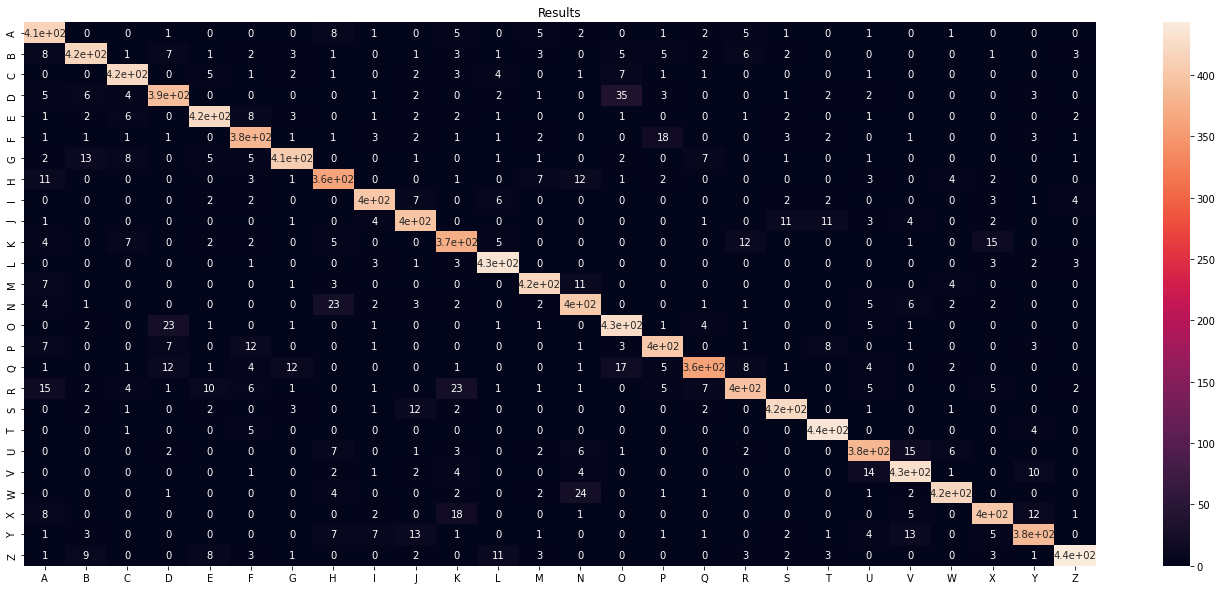

In [18]:
lett = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
cm = confusion_matrix(y_test, result)
plt.figure(figsize = (24, 10))
ax = sns.heatmap(cm, annot = True)
ax.set_title("Results")
ax.xaxis.set_ticklabels(lett)
ax.yaxis.set_ticklabels(lett)
plt.show()

Results for default Random Forest modell

In [13]:
print(classification_report(y_test, result))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       447
           1       0.90      0.84      0.87       473
           2       0.92      0.94      0.93       450
           3       0.86      0.86      0.86       458
           4       0.92      0.90      0.91       454
           5       0.88      0.88      0.88       425
           6       0.92      0.89      0.91       456
           7       0.86      0.86      0.86       409
           8       0.91      0.90      0.91       430
           9       0.84      0.86      0.85       436
          10       0.84      0.86      0.85       426
          11       0.91      0.94      0.92       449
          12       0.92      0.96      0.94       445
          13       0.89      0.88      0.88       458
          14       0.86      0.91      0.88       468
          15       0.87      0.89      0.88       446
          16       0.90      0.81      0.86       431
          17       0.90    

## Gridsearch RandomForest

In [20]:
max_depth  = [5, 10, 15, 20, 25, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
rfc_result = []
for d in max_depth:
    delta_rfc = RandomForestClassifier(random_state=42, max_depth=d)
    delta_rfc.fit(tr_data, y_data)
    delta_result = delta_rfc.predict(test_data_prepared)
    rfc_result.append(delta_result)

In [21]:
all_items = len(y_test)
all_res = []
for item in rfc_result:
    t = item - y_test
    corr = np.sum(t==0)
    all_res.append(corr/all_items)

The testresults on every gridsearch model for Random Forest

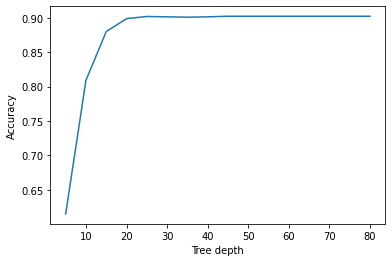

In [22]:
plt.plot(max_depth, all_res)
plt.ylabel("Accuracy")
plt.xlabel("Tree depth")
plt.show()

In [ ]:
rfc = RandomForestClassifier()
# defining parameter range
param_grid = {'max_depth':[5, 10, 15, 20, 25, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]}
  
grid_RFC = GridSearchCV(rfc, param_grid, refit = True, cv=5, verbose=3)
# fitting the model for grid search
grid_RFC.fit(tr_data, y_data)

In [52]:
best_model = grid_RFC.best_estimator_
grid_RFC.best_params_

{'max_depth': 65}

In [53]:
result = best_model.predict(test_data_prepared)

Results

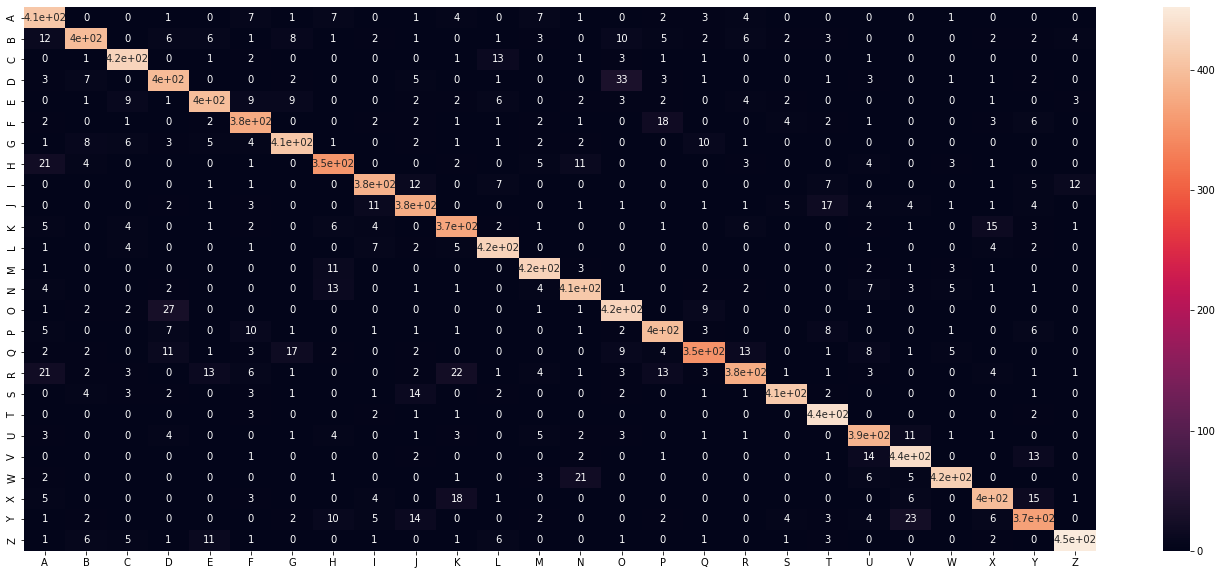

In [54]:
lett = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
cm = confusion_matrix(y_test, result)
plt.figure(figsize = (24, 10))
ax = sns.heatmap(cm, annot = True)
ax.set_title("Results")
ax.xaxis.set_ticklabels(lett)
ax.yaxis.set_ticklabels(lett)
plt.show()

In [55]:
print(classification_report(y_test, result))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       447
           1       0.91      0.84      0.87       473
           2       0.92      0.94      0.93       450
           3       0.85      0.86      0.86       458
           4       0.90      0.88      0.89       454
           5       0.86      0.89      0.87       425
           6       0.90      0.90      0.90       456
           7       0.86      0.87      0.86       409
           8       0.91      0.89      0.90       430
           9       0.85      0.87      0.86       436
          10       0.85      0.87      0.86       426
          11       0.91      0.94      0.92       449
          12       0.92      0.95      0.93       445
          13       0.89      0.90      0.89       458
          14       0.86      0.91      0.88       468
          15       0.88      0.89      0.89       446
          16       0.90      0.81      0.85       431
          17       0.90    

### Testing model on Paint images

In [88]:

file_lst = ['paint/N.jpg','paint/S.jpg','paint/J.jpg','paint/H2.jpg','paint/G.jpg','paint/F.jpg','paint/object.jpg','paint/E.jpg',
            'paint/K.jpg']
img_lst = [ np.transpose(cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)) for file_name in file_lst]

In [58]:
my_pipeline_predict = Pipeline([('transformed_dataset', EMNISTDataPreparation())])

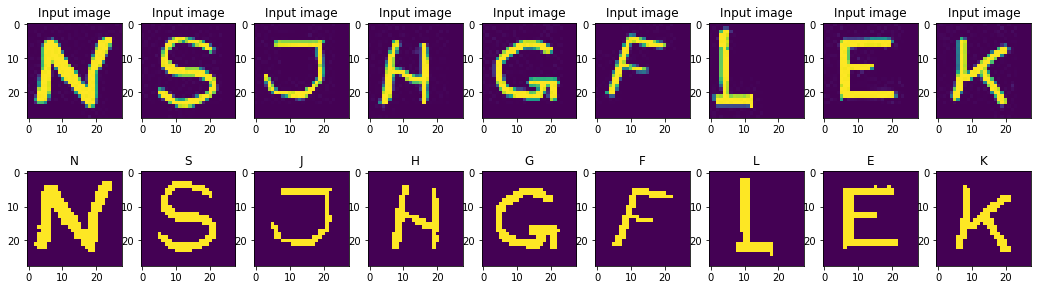

In [106]:
transform_drawings = my_pipeline_predict.fit_transform(img_lst)

fig, ax = plt.subplots(2, len(img_lst), figsize =(18,5))
for idx,drawing in enumerate(transform_drawings):
    result_tree = clf_tree.predict(drawing.reshape(-1, 784))
    ax[0,idx].imshow(np.transpose(img_lst[idx]).reshape(28,28))
    ax[0,idx].set_title("Input image")
    ax[1,idx].set_title(letter_dict[result_tree[0]])
    ax[1,idx].imshow(drawing.reshape(28,28))

---------------------

# SVM

This notebook does not contain Gridsearch on SVC model.  
The proceess has been explored and training time ended at >500 minutes.  
Beest results are being used below.

In [114]:
from sklearn.svm import SVC

SVC_clf = SVC(C=100, gamma=0.001) 
# fitting the model with pipeline data
SVC_clf.fit(tr_data, y_data)

SVC(C=100, gamma=0.001)

In [115]:
result = SVC_clf.predict(test_data_prepared)

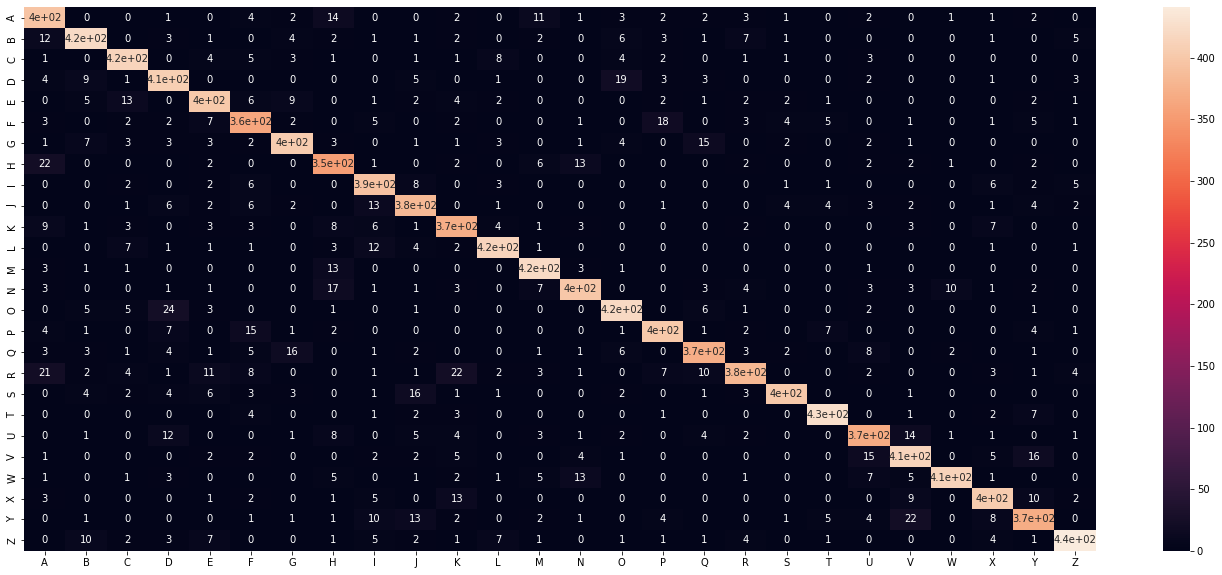

In [116]:
lett = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
cm = confusion_matrix(y_test, result)
plt.figure(figsize = (24, 10))
ax = sns.heatmap(cm, annot = True)
ax.set_title("Results")
ax.xaxis.set_ticklabels(lett)
ax.yaxis.set_ticklabels(lett)
plt.show()

In [117]:
print(classification_report(y_test, result))

              precision    recall  f1-score   support

           0       0.81      0.88      0.85       447
           1       0.89      0.89      0.89       473
           2       0.90      0.92      0.91       450
           3       0.84      0.89      0.87       458
           4       0.88      0.88      0.88       454
           5       0.83      0.85      0.84       425
           6       0.90      0.89      0.89       456
           7       0.82      0.87      0.84       409
           8       0.86      0.92      0.89       430
           9       0.85      0.88      0.86       436
          10       0.84      0.87      0.86       426
          11       0.93      0.92      0.93       449
          12       0.91      0.95      0.93       445
          13       0.90      0.87      0.89       458
          14       0.89      0.90      0.89       468
          15       0.90      0.90      0.90       446
          16       0.89      0.86      0.87       431
          17       0.90    

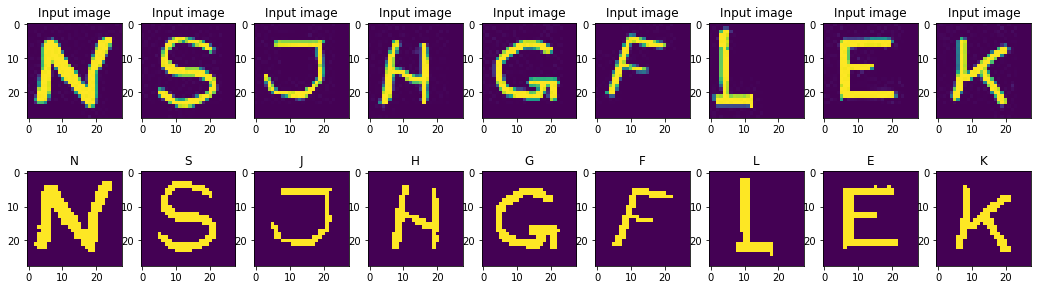

In [118]:
transform_drawings = my_pipeline_predict.fit_transform(img_lst)

fig, ax = plt.subplots(2, len(img_lst), figsize =(18,5))
for idx,drawing in enumerate(transform_drawings):
    result_tree = clf_tree.predict(drawing.reshape(-1, 784))
    ax[0,idx].imshow(np.transpose(img_lst[idx]).reshape(28,28))
    ax[0,idx].set_title("Input image")
    ax[1,idx].set_title(letter_dict[result_tree[0]])
    ax[1,idx].imshow(drawing.reshape(28,28))